![DSME-logo](./static/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---
A2C Impementation

Notebook Authors: Ramil Sabirov

Orignal Paper: [Asynchronous Methods for Deep Reinforcement Learning](https://arxiv.org/abs/1602.01783v2)

Additional References:
1. Generalised Advantage Estimate:
    * [High-Dimensional Continuous Control Using Generalized Advantage Estimation](https://arxiv.org/abs/1506.02438)
2. OpenAI A2C vs. A3C:
    * [Blog post A2C/A3C](https://openai.com/blog/baselines-acktr-a2c/)

## Library Imports

In [1]:
import os
import time
import random
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from tqdm import notebook
from easydict import EasyDict as edict
from IPython.display import Video

import utils.helper_fns as hf

import gymnasium as gym
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

os.environ['SDL_VIDEODRIVER']='dummy'
os.environ['WANDB_NOTEBOOK_NAME'] = 'a2c.ipynb'

plt.rcParams['figure.dpi'] = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

## Initializations

### Experiment Init

We primarily use dictionaries for initializing experiment parameters and training hyperparameters. We use the `EasyDict` (imported as `edict`) library, which allows us to access dict values as attributes while retaining the operations and properties of the original python `dict`! [[Github Link](https://github.com/makinacorpus/easydict)]

In this notebook, we use a few `dicts`, one of which is `exp`. It is initialized in the following cell and has keys and values containing information about the experiment being run. Though the dict is initialized in this section, we keep adding new keys and values to the dict in the later sections as well.  

This notebook supports gym environments with observation space of type `gym.spaces.Box` and action space of type `gym.spaces.Discrete`. Eg: Acrobot-v1, CartPole-v1, MountainCar-v0

In [2]:
exp = edict()

exp.exp_name = 'A2C'  # algorithm name, in this case it should be 'A2C'
exp.env_id = 'CartPole-v1'  # name of the gym environment to be used in this experiment. Eg: Acrobot-v1, CartPole-v1, MountainCar-v0
exp.device = device.type  # save the device type used to load tensors and perform tensor operations

set_random_seed = True  # set random seed for reproducibility
exp.seed = 1

# project name under which logs are saved on to Weights & Biases (if weights and biases logging is enabled)
# if the project does not exist in wandb, it will be created automatically
wandb_prj_name = f"RLLBC_{exp.env_id}"

# name prefix for files logged in this notebook
exp.run_name = f"{exp.env_id}__{exp.exp_name}__{exp.seed}__{datetime.now().strftime('%y%m%d_%H%M%S')}"

if set_random_seed:
    random.seed(exp.seed)
    np.random.seed(exp.seed)
    torch.manual_seed(exp.seed)
    torch.backends.cudnn.deterministic = set_random_seed

### Agent Model Class

The Agent class consists of the `critic` and `actor` models that are learned during training. Both models take the state as the input. The `actor` evaluates the state to a probability distribution of the action space. The `critic` evaluates to a scalar value that is seen as an approximation of the value function. In the following there are two different Agent classes. The first class, `Agent`, uses one MLP for the `critic` and another one for the `actor`. In the second, `Agent_shared`, the `actor` and `critic` share every layer except for the last.

An Agent class has three methods: 
1. `get_action_and_value` evaluates the networks for `actor` and `critic` and returns an action sampled from the resulting probability distribution of the `actor` and the value approximation as returned by the `critic`. It also returns the logarithm of the action probability $\log \pi(a_t|s_t)$ which is used for obtaining gradient estimates for training, as well as the entropy of the probability distribution.
2. `get_value` evalutes the network for the `critic` only and returns the resulting value function approximation.
3. `get_action` valuates the network for the `actor` only to receive the probability distribution and either samples an action from that distribution (greedy = false) or returns the action with the maximal probability (greedy = true). 

In [3]:
class Agent(nn.Module):

    def __init__(self, env):
        super().__init__()

        self.value_network = nn.Sequential(
            nn.Linear(np.array(env.single_observation_space.shape).prod(), 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

        self.policy_network = nn.Sequential(
            nn.Linear(np.array(env.single_observation_space.shape).prod(), 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, env.single_action_space.n),
        )

    def get_action_and_value(self, x):
        value, logits = self.value_network(x), self.policy_network(x)
        probs = Categorical(logits=logits)
        action = probs.sample()

        return action, probs.log_prob(action), probs.entropy(), value

    def get_value(self, x):
        return self.value_network(x)

    def get_action(self, x, greedy=False):

        logits = self.policy_network(x)

        if greedy:
            action = logits.argmax(1)
        else:
            probs = Categorical(logits=logits)
            action = probs.sample()
        return action

In [4]:
class Agent_shared(nn.Module):

    def __init__(self, env):
        super().__init__()

        # shared layers between actor and critic
        self.network = nn.Sequential(
            nn.Linear(np.array(env.single_observation_space.shape).prod(), 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
        )

        # linear layers for actor and critic
        self.value_layer = nn.Linear(64, 1)
        self.action_layer = nn.Linear(64, env.single_action_space.n)

    def get_action_and_value(self, x):
        out = self.network(x)
        value, logits = self.value_layer(out), self.action_layer(out)
        probs = Categorical(logits=logits)
        action = probs.sample()

        return action, probs.log_prob(action), probs.entropy(), value

    def get_value(self, x):
        out = self.network(x)
        return self.value_layer(out)

    def get_action(self, x, greedy=False):
        out = self.network(x)
        logits = self.action_layer(out)

        if greedy:
            action = logits.argmax(1)
        else:
            probs = Categorical(logits=logits)
            action = probs.sample()
        return action

### Training Params & Agent Hyperparams

The parameters and hyperparameters in this section are broadly categorized as below:
1. Flags for logging: 
    - Stored in the `exp` dict. 
    - This notebook uses tensorboard logging by default to log experiment metrics. These tb log files are saved in the directory `logs/<exp.exp_type>/<exp.run_name>/tb`. (to learn about `exp.exp_type` refer point 3. below)
    - To enable logging of gym videos of the agent's interaction with the env set `exp.capture_video = True`
    - Patch tensorboard logs and gym videos to Weigths & Biases (wandb) by setting `exp.enable_wandb_logging = True`
2. Flags and parameters to generate average performance throughout training:
    - Stored in the `exp` dict
    - If `exp.eval_agent = True`, the performance of the agent during it's training is saved in the corresponding logs folder. You can later used this to compare the performance of your current agent with other agents during their training (in Section 1.4.2).
    - Every `exp.eval_frequency` episodes the trained agent is evaluated using the `envs_eval` by playing out `exp.eval_count` episodes
    - To speed up training set `exp.eval_agent = False` 
3. Create experiment hierarchy inside log folders:
    - if `exp.exp_type` is None, experiment logs are saved to the root log directory `logs`, ie, `/logs/<exp.run_name>`, otherwise they are saved to the directory `logs/<exp.exp_type>/<exp._name>`
4. Parameters and hyperparameters related to the algorithm:
    - Stored in the `hypp` dict
    - Quick reminder:  the `num_steps` key in the `hypp` dict is also a hyperparameter defined in Env & Rollout Buffer Init Section.

Note: 
1. If Weigths and Biases (wandb) logging is enabled, when you run the "Training The Agent" cell, enter your wandb's api key when prompted. 
2. Training takes longer when either gym video recording or agent evaluation during training is enabled. To speed up training set both `exp.capture_video` and `exp.eval_agent` to `False`.

In [5]:
hypp = edict()

# flags for logging purposes
exp.enable_wandb_logging = True
exp.capture_video = True
exp.num_envs = 4  # number of parallel game environments

# flags to generate agent average performance during training.
exp.eval_agent = True  # disable to speed up training
exp.eval_count = 10
exp.eval_frequency = 20

# putting the run into the designated log folder for structuring
exp.exp_type = None  # directory the run is saved to. Should be None or a string value

# agent learning specific flags
hypp.total_timesteps = 300000

hypp.num_steps = 5  # number of environment steps before optimization
hypp.learning_rate = 3e-4  # learning rate used by the optimizer
hypp.gamma = 0.99  # discount factor of future rewards
hypp.gae_lambda = 0.95  # Coefficient for tradeoff between bias and variance in Generalized Advantage Estimate
hypp.norm_adv = True  # whether the advantages are normalized
hypp.ent_coef = 0.01  # weighting coefficient for the entropy loss
hypp.vf_coef = 0.5  # weighting coefficient for the value function loss
hypp.max_grad_norm = 1  # the maximum norm of the gradients computed
hypp.batch_size = int(exp.num_envs * hypp.num_steps)  # batch size for one step of gradient descent

## Training the Agent

Before we begin training the agent we first initalize the logging (based on the repsective flags in the `exp` dict), object of the `Agent` class and the optimizer, followed by an inital set of observations. 


Collect the trajectory i.e. executing the environment until it is finished, while keeping track of received rewards

After that comes the main training loop which comprises of:  
1. Run each parallel environment $k$ for `hypp.num_steps` steps and for each environment keep track of received rewards $R_t^k$ the logprobs $\log\pi_{\theta}(A_t^k|S_t^k)$, the entropies of the probability distributions $H_t^k$ as well as the value function approximation $v_t^k$
2. Compute advantage estimates $a_t^k$ for every time step using the generalized advantage estimation as well as the estimated return $g_t^k$
3. Constructing the loss function $$L = L_{policy} + c_v * L_{value} + c_e * L_{entropy}$$ consisting of a term for the policy $$L_{policy} = -\frac{1}{n*m}\sum_{k=1}^{m}\sum_{t=1}^{n}\log\pi_{\theta}(A_t^k|S_t^k) * a_t^k,$$ a term for the value function $$L_{value} = \frac{1}{n*m}\sum_{k=1}^{m}\sum_{t=1}^{n}\frac{1}{2}(v_t^k - g_t^k)^2,$$ and a term for the entropy $$L_{entropy} = -\frac{1}{n*m}\sum_{k=1}^{m}\sum_{t=1}^{n} H_t^k.$$ The coefficients $c_v$ and $c_e$ are managing the relative importance of the different terms.
4. Perform gradient descent (possibly with clipped gradient). That simultaneously tries to increase the policy return, decrease the error of value function approximation and increase the entropy (to support exploration)

Post completion of the main training loop, we save a copy of the following in the directory `logs/<exp.exp_type>/<exp.run_name>`:
1. `exp` and `hypp` dicts into a `.config` file 
2. `agent` (instance of `Agent` class) into a `.pt` file for later evaluation
3. agent performance progress throughout training into a `.csv` file if `exp.eval_agent=True`

Note: we have two vectorised gym environments, `envs` and `envs_eval` in the initalizations. `envs` is used to fill the rollout buffer with trajectories and `envs_eval` is used to evaluate the agent performance at different stages of training.

In [6]:
# reinit run_name
exp.run_name = f"{exp.env_id}__{exp.exp_name}__{exp.seed}__{datetime.now().strftime('%y%m%d_%H%M%S')}"

# Init tensorboard logging and wandb logging
writer = hf.setup_logging(wandb_prj_name, exp, hypp)

# Create two vectorized envs: one to fill the rollout buffer with trajectories and
# another to evaluate the agent performance at different stages of training
envs = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed + i) for i in range(exp.num_envs)])
envs_eval = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed + i) for i in range(exp.num_envs)])

# Init list to track agent's performance throughout training
tracked_returns_over_training = []
tracked_episode_len_over_training = []
tracked_episode_count = []
last_evaluated_episode = None  # stores the episode_step of when the agent's performance was last evaluated
greedy_evaluation = False  # whether to perform the evaluation in a greedy way or not
eval_max_return = -float('inf')

# Create Agent class instance and network optimizer
agent = Agent(envs).to(device)
# agent = Agent_shared(envs).to(device)
optimizer = optim.Adam(agent.parameters(), lr=hypp.learning_rate)

# Init observation to start learning
gradient_step = 0
global_step = 0
episode_step = 0
start_time = time.time()
obs, _ = envs.reset()
next_obs = torch.Tensor(obs).to(device)
next_done = torch.zeros(exp.num_envs).to(device)
num_updates = hypp.total_timesteps // hypp.batch_size

pbar = notebook.tqdm(range(1, num_updates + 1))

# training loop
for update in pbar:
    # initialize the rollout buffer
    observations = torch.zeros((hypp.num_steps, exp.num_envs) + envs.single_observation_space.shape).to(device)
    actions = torch.zeros((hypp.num_steps, exp.num_envs) + envs.single_action_space.shape).to(device)
    logprobs = torch.zeros((hypp.num_steps, exp.num_envs)).to(device)
    rewards = torch.zeros((hypp.num_steps, exp.num_envs)).to(device)
    dones = torch.zeros((hypp.num_steps, exp.num_envs)).to(device)
    values = torch.zeros((hypp.num_steps, exp.num_envs)).to(device)
    entropies = torch.zeros((hypp.num_steps, exp.num_envs)).to(device)

    # run environments for specified number of steps
    for step in range(0, hypp.num_steps):
        global_step += 1 * exp.num_envs
        observations[step] = next_obs
        dones[step] = next_done

        # get action from agent + bookkeeping
        action, logprob, entropy, value = agent.get_action_and_value(next_obs)
        values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob
        entropies[step] = entropy

        # take action in environment
        next_obs, reward, terminations, truncations, infos = envs.step(action.cpu().numpy())
        done = np.logical_or(terminations, truncations) 
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)

        if "final_info" in infos: 
            for info in infos["final_info"]:
                if info and "episode" in info:
                    episode_step += 1
                    pbar.set_description(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                    writer.add_scalar("rollout/episodic_return", info["episode"]["r"], global_step)
                    writer.add_scalar("rollout/episodic_length", info["episode"]["l"], global_step)
                    writer.add_scalar("Charts/episode_step", episode_step, global_step)
                    writer.add_scalar("Charts/gradient_step", gradient_step, global_step)
                    break

        # evaluation of the agent
        if exp.eval_agent and (episode_step % exp.eval_frequency == 0) and last_evaluated_episode != episode_step:
            last_evaluated_episode = episode_step
            tracked_return, tracked_episode_len = hf.evaluate_agent(envs_eval, agent, exp.eval_count,
                                                                    exp.seed, greedy_actor=greedy_evaluation)
            tracked_returns_over_training.append(tracked_return)
            tracked_episode_len_over_training.append(tracked_episode_len)
            tracked_episode_count.append([episode_step, global_step])

            # if there has been improvement of the model - save model, create video, log video to wandb
            if np.mean(tracked_return) > eval_max_return:
                eval_max_return = np.mean(tracked_return)
                # call helper function save_and_log_agent to save model, create video, log video to wandb
                hf.save_and_log_agent(exp, envs, Agent, agent, episode_step,
                                      greedy=greedy_evaluation, print_path=False)

    # calculate advantages
    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(hypp.num_steps)):
            if t == hypp.num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + hypp.gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = delta + hypp.gamma * hypp.gae_lambda * nextnonterminal * lastgaelam
        returns = advantages + values

    # update policy and value function
    # normalizing advantages
    if hypp.norm_adv:
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # flatten the batch
    b_observations = observations.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)
    b_entropies = entropies.reshape(-1)

    # policy Loss
    policy_loss = -(b_logprobs * b_advantages).mean()

    # value Loss - MSE
    value_loss = 0.5 * ((b_values - b_returns)**2).mean()

    # entropy loss
    entropy_loss = -b_entropies.mean()

    total_loss = policy_loss + hypp.vf_coef * value_loss + hypp.ent_coef * entropy_loss

    optimizer.zero_grad()

    total_loss.backward()

    # clipping the gradients
    nn.utils.clip_grad_norm_(agent.parameters(), hypp.max_grad_norm)

    optimizer.step()
    gradient_step += 1

    # calculating the explained variance
    y_pred, y_true = b_values.cpu().detach().numpy(), b_returns.cpu().detach().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    # logging metrics
    writer.add_scalar("train/value_loss", value_loss.item(), global_step)
    writer.add_scalar("train/policy_loss", policy_loss.item(), global_step)
    writer.add_scalar("train/entropy", -entropy_loss.item(), global_step)
    writer.add_scalar("train/explained_variance", explained_var, global_step)
    writer.add_scalar("others/SPS", int(global_step / (time.time() - start_time)), global_step)
    writer.add_scalar("Charts/gradient_step", gradient_step, global_step)
    writer.add_scalar("Charts/episode_step", episode_step, global_step)


# one last evaluation stage
if exp.eval_agent:
    tracked_return, tracked_episode_len = hf.evaluate_agent(envs_eval, agent, exp.eval_count, exp.seed, greedy_evaluation)
    tracked_returns_over_training.append(tracked_return)
    tracked_episode_len_over_training.append(tracked_episode_len)
    tracked_episode_count.append([episode_step, global_step])

    # if there has been improvement of the model - save model, create video, log video to wandb
    if np.mean(tracked_return) > eval_max_return:
        eval_max_return = np.mean(tracked_return)
        # call helper function save_and_log_agent to save model, create video, log video to wandb
        hf.save_and_log_agent(exp, envs, Agent, agent, episode_step, greedy=greedy_evaluation, print_path=False)

    hf.save_tracked_values(tracked_returns_over_training, tracked_episode_len_over_training,
                           tracked_episode_count, exp.eval_count, exp.run_name, exp.exp_type)

envs.close()
writer.close()
if wandb.run is not None:
    wandb.finish(quiet=True)
    wandb.init(mode="disabled")

hf.save_train_config_to_yaml(exp, hypp)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lukas-kesper98. Use `wandb login --relogin` to force relogin


  0%|          | 0/15000 [00:00<?, ?it/s]

## Compare Trained Agents and Display Behaviour

### Display Trained Agent Behavior

Set `agent_name` and `agent_exp_type` to load the saved agent model in the respective log folder and generate a video of the agent's interaction with the gym environment. After the cell is executed, you should see a video embedding as output, and the video is also available in the directory: `/logs/<exp.exp_type>/<exp.run_name>/videos` 

In [7]:
agent_name = exp.run_name
agent_exp_type = exp.exp_type  # both are needed to identify the agent location

exp_folder = "" if agent_exp_type is None else agent_exp_type
filepath, _ = hf.create_folder_relative(f"{exp_folder}/{agent_name}/videos")

hf.record_video(exp.env_id, envs, Agent, agent_name, f"{filepath}/best.mp4", exp_type=agent_exp_type, greedy=True)
Video(data=f"{filepath}/best.mp4", html_attributes='loop autoplay', embed=True)

### Compare Performance of Agents During Training

During the training loop, if `exp.eval_agent = True`, the performance progress of the agent during its training is saved in a csv file. To compare the saved progress of different agents, create a `dict` containing the parent folder's name of each of the csv files and use the helper function `plotter_agents_training_stats`.

To load the data, you can either set `eval_params.run_name00 = exp.run_name` (if only a `tracked_performance_training.csv` file for the corresponding `exp.run_name` exists) or manually enter the folder name containing the csv file. 

If the agent performance you want to load is inside an exp_type folder, set `eval_params.exp_type00` to experiment type, and if not, set it to `None`. 

You can add more than one experiment by initializing dict keys and values of the format `eval_params.run_namexx` and `eval_params.exp_typexx`.

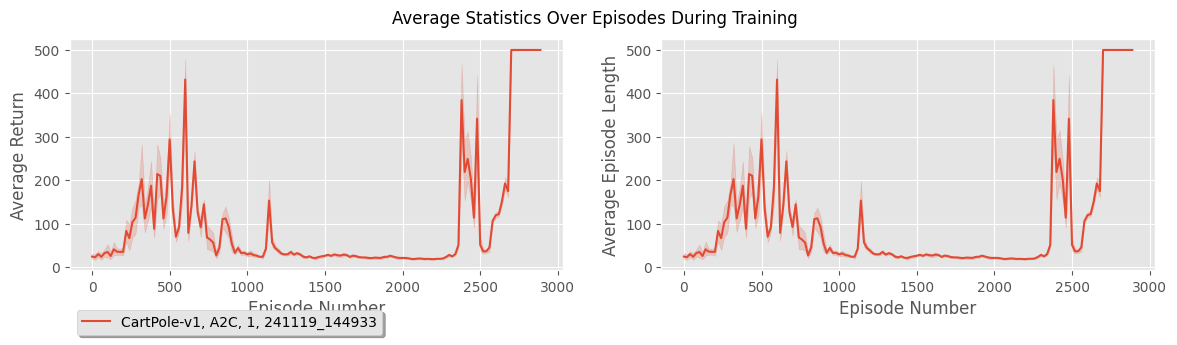

In [8]:
eval_params = edict()  # eval_params - evaluation settings for trained agent

eval_params.run_name00 = exp.run_name
eval_params.exp_type00 = exp.exp_type

# eval_params.run_name01 = "CartPole-v1__PPO__1__230302_224624"
# eval_params.exp_type01 = None

# eval_params.run_name02 = "CartPole-v1__PPO__1__230302_221245"
# eval_params.exp_type02 = None

agent_labels = []

episode_axis_limit = None

hf.plotter_agents_training_stats(eval_params, agent_labels, episode_axis_limit, plot_returns=True, plot_episode_len=True)

## TensorBoard Inline

In [9]:
# %load_ext tensorboard
# %tensorboard --logdir runs --host localhost